In [1]:
import logging
import numpy as np
import pandas as pd
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders

import itertools
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [2]:
df = pd.read_csv('aapl_stock_prices.csv')
# Convert the timestamp to datetime as follows. 's' for seconds, 'ms' for milliseconds
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)
df.dropna(inplace=True)

# rebuild the index
# df.index = pd.date_range(start=df.index[0], end=df.index[-1], freq="b")

df.head()


,close,high,low,open,volume,date
timestamp,,,,,,
2024-02-06 14:30:00,189.300003,189.309998,186.770004,186.860001,43490800,2024-02-06
2024-02-07 14:30:00,189.410004,191.050003,188.610001,190.639999,53439000,2024-02-07
2024-02-08 14:30:00,188.320007,189.539993,187.350006,189.389999,40962000,2024-02-08
2024-02-09 14:30:00,188.850006,189.990005,188.000000,188.649994,45155200,2024-02-09
2024-02-12 14:30:00,187.149994,188.669998,186.789993,188.419998,41781900,2024-02-12


## Plot the stock prices

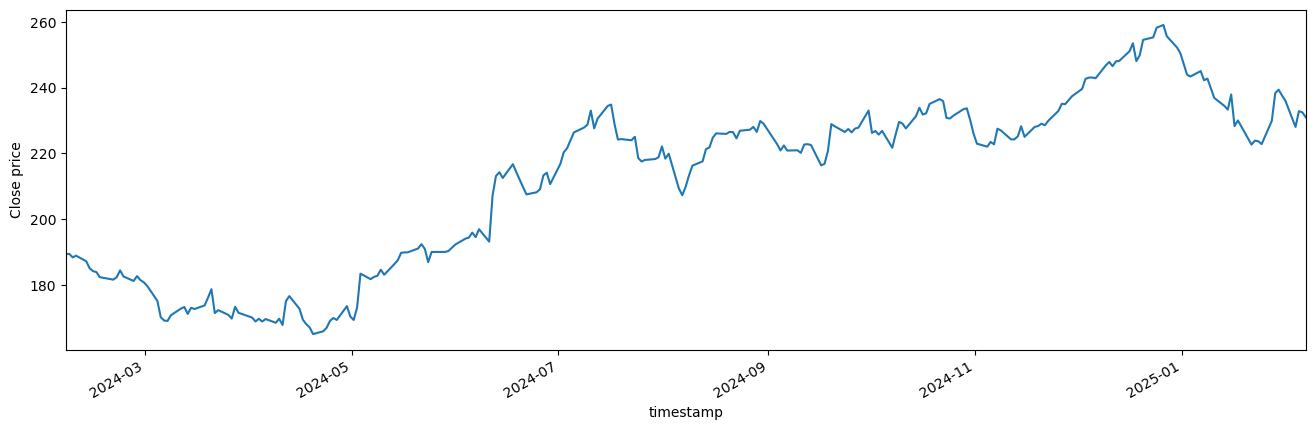

In [91]:
ax = df['close'].plot(figsize=(16,5))
ax.autoscale(axis='x',tight=True)
ax.set(ylabel='Close price');

## Plot the trend

In [92]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# Tuple unpacking
cycle, trend = hpfilter(df['close'], lamb=1600)
df['trend'] = trend

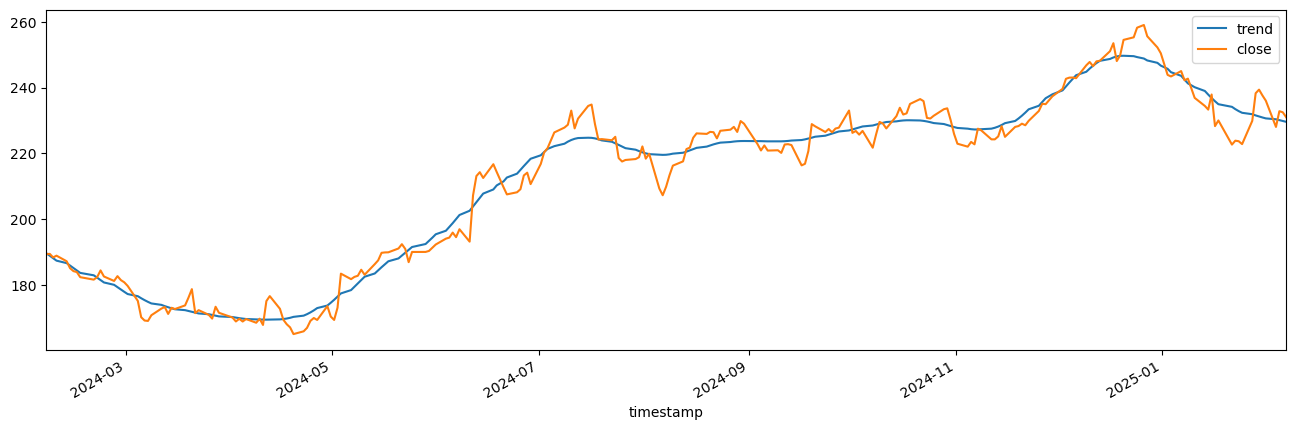

In [93]:
df[['trend','close']].plot(figsize=(16,5)).autoscale(axis='x',tight=True);

# Using ARIMA model to forecast the close price
The purpose behind this is to predict what happens next.<br>
What's our best guess for next month's value? For the next six months?

In this section we'll look to extend our models into the future. First we'll divide known data into training and testing sets, and evaluate the performance of a trained model on known test data.

* Goals
  * Choose a criterion to evaluate our model
  * Choose best ARIMA order using train dataset
  * Evaluate the model to confirm the ARIMA order

### AIC / BIC Criterion to evaluate our ARIMA model
More sophisticated tests include the <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'><strong>Akaike information criterion</strong></a> (AIC) and the <a href='https://en.wikipedia.org/wiki/Bayesian_information_criterion'><strong>Bayesian information criterion</strong></a> (BIC).

The AIC evaluates a collection of models and estimates the quality of each model relative to the others. Penalties are provided for the number of parameters used in an effort to thwart overfitting. The lower the AIC and BIC, the better the model should be at forecasting.

These functions are available as

&nbsp;&nbsp;&nbsp;&nbsp;<tt>from from statsmodels.tools.eval_measures import aic, bic</tt>

but we seldom compute them alone as they are built into many of the statsmodels tools we use.

### Choose best ARIMA Orders
ARIMA, or Autoregressive Independent Moving Average is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period.
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.